# FIT5196 Assessment 4
# FIT5196 Task  in Assessment 4
#### Student Name: Pattranit Chaiyabud and Viet Tai Le
#### Student ID: 30304148 and 29975336 

Date: 28/10/2019

Version: 1.0

Environment: Python 3.6.0 and Anaconda 4.3.0 (64-bit)

Libraries used:
* re (for regular expression, included in Anaconda Python 3.6.0)
* os (for executing in subshell, included in Anaconda Python 3.6.0)
* networkx (for draw graph, include in Anaconda Python 3.6.0)
* sklearn ( for regression, include in Anaconda Python 3.6.0 )
* pandas (for dataframe, included in Anaconda Python 3.6.0) 
* sklearn (for linear regression)
* geopandas( reading shapefile)



## 1. Introduction
For this assessment, we will integrate several datasets into one single schema and find and fix possible problems in the data. There are 2 tasks in total.

In Task1: Data Integration
The column that will be calculated are as the following:
- Suburb
- train_station_id
- distance_to_train_station
- travel_min_to_CBD
- over_priced?
- crime_A_average
- crime_B_average
- crime_C_average
- closest_primary_school
- distance_to_closest_primary
- primary_school_ranking
- closest_secondary_school
- distance_to_closest secondary
- secondary_school_ranking

In Task2: Data reshaping
We will study the effect ofdifferent normalization/transformation methods on the following attributes assuming that we want to build a linear model on `Price`: 
- Rooms
- crime_C_average
- travel_min_to_CBD
- property_age attributes


## 2.  Import libraries 

In [1]:
import matplotlib 
%matplotlib inline
import shapefile
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from datetime import datetime
import geopandas
import pandas as pd
import re
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import html
import difflib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from math import sqrt, log
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import metrics

<b> Examine data </b>

In [2]:
# read original data
df1=pd.read_csv('Group148.csv')
df1.head(5)

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID850321692,46/121 Rathdowne St,3,u,735000.0,3/12/2016,1.0,2.0,3455.0,129.0,-37.80420,144.96910
1,ID658162778,6 Gray La,3,h,2035000.0,29/04/2017,1.0,1.0,185.0,129.0,-37.84350,144.95380
2,ID172575296,12 Borrie St,3,h,703000.0,18/06/2016,2.0,1.0,597.0,59.0,-37.70660,145.02030
3,ID253601222,47 Churchill Wy,3,h,710000.0,19/08/2017,1.0,2.0,837.0,59.0,-37.79682,145.30467
4,ID201623150,20a Park Rd,3,h,1100000.0,14/05/2016,1.0,1.0,111.0,18.0,-37.85250,145.00710


In [3]:
df1.nunique()

ID            681
Address       681
Rooms           7
Type            3
Price         416
Date           57
Bathroom        6
Car             7
Landsize      436
Age            77
Lattitude     643
Longtitude    647
dtype: int64

There are some duplicate rows on our data.  Hence, we need to drop all duplicate rows

In [4]:
df1=df1.drop_duplicates(subset=df1.columns,keep='first')

<b> Suburb </b>

Fristly, we read the shapefile to extract corrdinate value of each suburb by geopandas. And then, based on Lattitude and Longtitude of each house, we can define suburb of each house. 

In [5]:
sf = geopandas.read_file("./VIC_LOCALITY_POLYGON_shp.shp") 
sf.head(2)

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."


We can see on above dataframe that column geometry contains range of suburbs. To look for suburb of each house, firstly, we extract lat and lon into point and then use method within() to check that point in suburb or not 

In [6]:
#extract corrdinate of each house 
all_points=[ Point(point) for point in zip(df1.Longtitude,df1.Lattitude)]
# list contains suburb
list_sub=[]

for point in all_points:
    for geo,sub in zip(sf['geometry'],sf['VIC_LOCA_2']):
        #if point in geo then add its corresponding suburb  
        if point.within(geo):
            list_sub.append(sub)     
# adding suburb column on dataframe
df1.insert(2, 'Suburb', list_sub)

<b> Train_station_id and distance</b>

My approach here is that firstly we filter all trip that has southern cross station as one of the stops. Stop sequence of southern cross should be greater than 1 (avoid southern cross as begining stop). I will named trips here as southern trip 

The second step, we try to filter trips from southern trip that run on weekdays by intersection with trip from dataframe which is joining datasets from calendars and trips.  

The third step, for each trip in southern trip, we removed trip that dont have any stops departure between 7:00 and 9:30.  After that, we also choose stops that departure between 7am and 9:30am and has stop sequence before stop sequence of Southern Cross station. 

And then, we will calculate distance of each house to all stops by Haversine formula and then we choose station that has nearest distance



In [7]:
# Reading all dataset from data 1 and data2 since they contains information of routes,stops of train station
stops1 = pd.read_csv('./gtfs/1/google_transit/stops.txt', sep=",")
stop_times1=pd.read_csv('./gtfs/1/google_transit/stop_times.txt', sep=",")
stop_times2=pd.read_csv('./gtfs/2/google_transit/stop_times.txt', sep=",")
stops2 = pd.read_csv('./gtfs/2/google_transit/stops.txt', sep=",")
calendar1 = pd.read_csv('./gtfs/1/google_transit/calendar.txt', sep=",")
trips1=pd.read_csv('./gtfs/1/google_transit/trips.txt', sep=",")
calendar2=pd.read_csv('./gtfs/2/google_transit/calendar.txt', sep=",")
trips2 = pd.read_csv('./gtfs/2/google_transit/trips.txt', sep=",")



In [8]:
# Extract stop_id of Southern Cross Railway
s_id1=stops1[stops1.stop_name=='Southern Cross Railway Station (Melbourne City)'].stop_id.tolist()[0]
s_id2=stops2[stops2.stop_name=='Southern Cross Railway Station (Melbourne City)'].stop_id.tolist()[0]


In [9]:
# Extract trip run to Southern Cross
s_trip1=stop_times1[(stop_times1.stop_id==s_id1)& (stop_times1.stop_sequence>1) ].trip_id.tolist()
s_trip2=stop_times2[(stop_times2.stop_id==s_id2)& (stop_times2.stop_sequence>1) ].trip_id.tolist()


In [10]:
# Removed all trips run on weekends
# Joining trips and calendar dataset
result1=pd.merge(trips1, calendar1, on='service_id')
result2=pd.merge(trips2, calendar2, on='service_id')
# Filter trips run only weekdays
result1=result1[(result1.saturday==0) & (result1.sunday==0)]
result2=result2[(result2.saturday==0) & (result2.sunday==0)]
weekdays_trip1=result1.trip_id.tolist()
weekdays_trip2=result2.trip_id.tolist()
# Remove weekends trip from southern trip
s_trip1=[i for i in s_trip1 if i in weekdays_trip1 ]
s_trip2=[i for i in s_trip2 if i in weekdays_trip2]


In [11]:
# to get stops that departure between 7:00 and 9:30
dfstop1=stop_times1[stop_times1.trip_id.isin(s_trip1) & (stop_times1.departure_time>'07:00:00') &\
          (stop_times1.departure_time<'09:30:00')]

dfstop2=stop_times2[stop_times2.trip_id.isin(s_trip2) & (stop_times2.departure_time>'07:00:00') &\
          (stop_times2.departure_time<'09:30:00') ]
all_stops1=set(dfstop1.stop_id.tolist())
all_stops2=set(dfstop2.stop_id.tolist())

In [12]:
# removed all trip that dont have any stops between 7:00 and 9:30
morning_trip1=set(dfstop1.trip_id.tolist())
morning_trip2=set(dfstop2.trip_id.tolist())

In [13]:
# all stops before southern cross in morning trip
set_stops=set()
for trip in morning_trip1:
    # list of stopid between 7am and 9:30 in a trip 
    list1=dfstop1[dfstop1.trip_id==trip].stop_id.tolist()
    # stop sequence of Southern Cross in that trip
    s=stop_times1[(stop_times1.trip_id==trip) & (stop_times1.stop_id==s_id1)].stop_sequence.tolist()[0]
    for stopid in list1:
        # We try to remove stopid come after Southern Cross
        # if stop sequence of stopid before stop sequence of Southern Cross, it is a appropriate stopid
        if (dfstop1[(dfstop1.trip_id==trip) & (dfstop1.stop_id==stopid)]).stop_sequence.tolist()[0] <= s:
            set_stops.add(stopid)

            
for trip in morning_trip2:
    list2=dfstop2[dfstop2.trip_id==trip].stop_id.tolist()
    s=stop_times2[(stop_times2.trip_id==trip) & (stop_times2.stop_id==s_id2)].stop_sequence.tolist()[0]
    for stopid in list2:
        if (dfstop2[(dfstop2.trip_id==trip) & (dfstop2.stop_id==stopid)]).stop_sequence.tolist()[0] <= s:
            set_stops.add(stopid)
            

In [14]:
# dataframe that contains arrival time at Southern Cross station for each appropriate trip
dfid1=stop_times1[stop_times1.trip_id.isin(morning_trip1) & (stop_times1.stop_id==s_id1)]
dfid2=stop_times2[stop_times2.trip_id.isin(morning_trip2) & (stop_times2.stop_id==s_id2)]

In here, after we get all appropriate stops id, i extract corrdinate information of all stops

In [15]:
stops=pd.concat([stops1,stops2])
stops= stops[stops['stop_id'].isin(set_stops)]
# extract longtitude,lattitude and stop_id of each stop
all_stops=[point for point in zip(stops.stop_id,stops.stop_lon,stops.stop_lat)]

In [16]:
# extract longtitude,lattitude of all appropriate stop id
all_points=[ point for point in zip(df1.Longtitude,df1.Lattitude)]

In [17]:
# define the Haversine function 
def Haversine(lat1,lon1,lat2,lon2):
    """
    This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine
    formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    c = 2 ⋅ atan2( √a, √(1−a) )
    d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,378km);
    note that angles need to be in radians to pass to trig functions!
    """
    R = 6378
    lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d = R * c
    return round(d,4)

In [18]:
from math import sqrt
#Initialise list of station_id
station_id=[]
# Initialise list of distance
distance=[]
for point in all_points:
    # use min() to return closest value
    station_id.append(min(all_stops,key=lambda stop:Haversine(point[1],point[0],stop[2],stop[1]) )[0])
    distance.append(min([Haversine(point[1],point[0],stop[2],stop[1]) for stop in all_stops])*1000)


In [19]:
df1['train_station_id']=station_id
df1['distance_to_train_station']=distance

<b>avg travel min to southern cross</b> 

Based on what we find on previous steps, my code here is that we extract list of trip of each station. For each trip, we calculate time between that station to southern cross station. And then, we get average values. 

In [20]:
avg_travel=[]
for s in station_id:
    list0=[]
    if s in all_stops1:
        # list of trip that pass each station 
        mtrip=dfstop1[dfstop1.stop_id==s].trip_id.tolist()
        for trip in mtrip:
            s1 = dfstop1[(dfstop1.stop_id==s) &(dfstop1.trip_id==trip) ].departure_time.tolist()[0]
            s2 = dfid1[(dfid1.stop_id==s_id1) &(dfid1.trip_id==trip)].arrival_time.tolist()[0]
            FMT = '%H:%M:%S'
            # for each trip, if stop sequence of station before Southern cross station
            if datetime.strptime(s2, FMT) >= datetime.strptime(s1, FMT):
                tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
                list0.append(tdelta.seconds/60)
        avg_travel.append(sum(list0)/len(list0))
    if s in all_stops2:
        mtrip=dfstop2[dfstop2.stop_id==s].trip_id.tolist()
        for trip in mtrip:
            s1 = dfstop2[(dfstop2.stop_id==s) &(dfstop2.trip_id==trip) ].departure_time.tolist()[0]
            s2 = dfid2[(dfid2.stop_id==s_id2) &(dfid2.trip_id==trip)].arrival_time.tolist()[0]
            FMT = '%H:%M:%S'
            if datetime.strptime(s2, FMT) >= datetime.strptime(s1, FMT):
                tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
                list0.append(tdelta.seconds/60)
        avg_travel.append(sum(list0)/len(list0))

    
    

In [21]:
df1['travel_min_to_CBD']=avg_travel

<b>over_priced?</b>

My approach here is group property by ( number of bedrooms, number of bathrooms, number of parking_space,  property_type attributes, suburb,year). Then, for each group, we calculate its median. And we convert that dataframe to dictionary with median price as value and atribute as key. Based on dictionary, we compare house's price and its median price by its atrribute   

In [22]:
df1['Year']=[int(date[-4:]) for date in df1['Date']]

In [23]:
dict1=df1.groupby(['Suburb','Type','Rooms','Bathroom','Car','Year']).median()['Price'].to_dict()
overprice=[]
for s,t,r,br,c,p,y in zip(df1.Suburb,df1.Type,df1.Rooms,df1.Bathroom,df1.Car,df1.Price,df1.Year):
    v=(p > dict1[(s,t,r,br,c,y)])
    overprice.append(v)


In [24]:
# df1=df1.drop(columns=['Year'])
df1['over_priced?']=overprice

In [25]:
df1.head(5)

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,Year,over_priced?
0,ID850321692,46/121 Rathdowne St,CARLTON,3,u,735000.0,3/12/2016,1.0,2.0,3455.0,129.0,-37.80420,144.96910,19843,833.3,6.092593,2016,False
1,ID658162778,6 Gray La,ALBERT PARK,3,h,2035000.0,29/04/2017,1.0,1.0,185.0,129.0,-37.84350,144.95380,20043,2803.6,0.000000,2017,False
2,ID172575296,12 Borrie St,RESERVOIR,3,h,703000.0,18/06/2016,2.0,1.0,597.0,59.0,-37.70660,145.02030,20009,960.6,35.142857,2016,False
3,ID253601222,47 Churchill Wy,KILSYTH,3,h,710000.0,19/08/2017,1.0,2.0,837.0,59.0,-37.79682,145.30467,19877,1506.1,49.769231,2017,False
4,ID201623150,20a Park Rd,PRAHRAN,3,h,1100000.0,14/05/2016,1.0,1.0,111.0,18.0,-37.85250,145.00710,19946,628.5,18.214286,2016,False


## Crime

In order to deal with crime average of all type, we start with opening the excel file called `'crimebylocationdatatable-yearending31march2016.xlsx` by creating a Pandas `ExcelFile` object.

In [26]:
excel_data = pd.ExcelFile('crimebylocationdatatable-yearending31march2016.xlsx')
excel_data

Then it might be good to view all the sheets by their names.
So, let's check out what the names of the sheets we have in our Excel file are:

In [27]:
#view excel sheet
excel_data.sheet_names

['Contents', 'Table 1']

As you can see, there are two sheets in the excel data and what we need is `Tale 1`

In [28]:
# choose table1 sheet
df = excel_data.parse('Table 1')
# have a look and drop all NaN
df = df.dropna(0, how = 'all')
df = df.dropna(1, how = 'all')
# set the column name
df.columns = df.iloc[1]
# choose row from 2 onward
df=df[2:]

And here is the dataset after wrangling which is ready to be explored

In [29]:
df.head(5)

18,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
19,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
20,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
21,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
22,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
23,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


In [30]:
# reset the index
df.reset_index(level=0, inplace= True)
# drop old index
df = df.drop('index', axis=1)
# rename the columns name
df = df.rename(columns={'CSA Offence Division': 'Crime type', 'Local Government Area': 'LGA','Apr - Mar reference period':'Year','Offence Count':'Count'})
# segment only the column we want
df = df[['Crime type','LGA','Year','Count']]

In [31]:
df.head(5)

18,Crime type,LGA,Year,Count
0,A Crimes against the person,BANYULE,2012,4
1,A Crimes against the person,BANYULE,2012,568
2,A Crimes against the person,BANYULE,2012,132
3,A Crimes against the person,BANYULE,2012,12
4,A Crimes against the person,BANYULE,2012,46


Since we need the average crime of each type(A, B, C), sum all the `Count` according to `Crime type`, `LGA` or local government area and `year`

In [32]:
df = df.groupby(['Crime type','LGA','Year']).sum()   
df.reset_index(inplace= True)

In [33]:
df.head(5)

18,Crime type,LGA,Year,Count
0,A Crimes against the person,ALPINE,2012,72
1,A Crimes against the person,ALPINE,2013,78
2,A Crimes against the person,ALPINE,2014,85
3,A Crimes against the person,ALPINE,2015,99
4,A Crimes against the person,ALPINE,2016,93


Find the average in the three years prior to selling the property as the property. For example, if a property is sold in 2016, then you should calculate the average of the crime type A for 2013, 2014 and 2015.
In this case, the concept of `'Moving Average'` will be applied and we use `dataframe.rolling()` function provides the feature of rolling window calculations setting `min_periods` as 3 since we need three year of calculation.

In [34]:
df['Average'] =df.groupby(['Crime type','LGA']).Count.apply(lambda x: x.rolling(3,min_periods=3).mean())

In [35]:
df.head(5)

18,Crime type,LGA,Year,Count,Average
0,A Crimes against the person,ALPINE,2012,72,NaN
1,A Crimes against the person,ALPINE,2013,78,NaN
2,A Crimes against the person,ALPINE,2014,85,78.333333
3,A Crimes against the person,ALPINE,2015,99,87.333333
4,A Crimes against the person,ALPINE,2016,93,92.333333


After getting the overall average, we will separate the crime type for each column. Starting with A, B and C respectively
### Crime A average

In [36]:
# select only crime A
crime_a = df[df["Crime type"].str.startswith("A")]
# rename the column
crime_a = crime_a.rename(columns={'Average':'crime_A_average'})
# choose only year 2016 and 2017 result
crime_a = crime_a.loc[(crime_a['Year'] == 2015) | (crime_a['Year'] == 2016)][['LGA','Year','crime_A_average']]
# change year for understanding 
crime_a.loc[(crime_a['Year'] == 2016),'Year']=2017
crime_a.loc[(crime_a['Year'] == 2015),'Year']=2016
# reset index
crime_a.reset_index(level=0, inplace= True)
# drop old index
crime_a = crime_a.drop('index', axis=1)

In [37]:
crime_a.head(5)

18,LGA,Year,crime_A_average
0,ALPINE,2016,87.333333
1,ALPINE,2017,92.333333
2,ARARAT,2016,305.000000
3,ARARAT,2017,318.333333
4,BALLARAT,2016,1628.333333


### Crime B average

In [38]:
# select only crime B
crime_b = df[df["Crime type"].str.startswith("B")]
# rename the column
crime_b = crime_b.rename(columns={'Average':'crime_B_average'})
# choose only year 2016 and 2017 result
crime_b = crime_b.loc[(crime_b['Year'] == 2015) | (crime_b['Year'] == 2016)][['LGA','Year','crime_B_average']]
# change year for understanding 
crime_b.loc[(crime_b['Year'] == 2016),'Year']=2017
crime_b.loc[(crime_b['Year'] == 2015),'Year']=2016
# reset index
crime_b.reset_index(level=0, inplace= True)
# drop old index
crime_b = crime_b.drop('index', axis=1)

### Crime C average

In [39]:
# select only crime C
crime_c = df[df["Crime type"].str.startswith("C")]
# rename the column
crime_c = crime_c.rename(columns={'Average':'crime_C_average'})
# choose only year 2016 and 2017 result
crime_c = crime_c.loc[(crime_c['Year'] == 2015) | (crime_c['Year'] == 2016)][['LGA','Year','crime_C_average']]
# change year for understanding
crime_c.loc[(crime_c['Year'] == 2016),'Year']=2017
crime_c.loc[(crime_c['Year'] == 2015),'Year']=2016
# reset index
crime_c.reset_index(level=0, inplace= True)
# drop old index
crime_c = crime_c.drop('index', axis=1)

Next when the data of each local government is ready, we will map Suburb to its LGA from the file called `councils.txt` since we want the crime rate to be in each suburb.

In [40]:
# create empty dict
councils = {}
# open the file and wrangling
with open('councils.txt','r') as infile:
    for line in infile:
        line = re.sub(r'[\'\[\]\n]','',line)
        line = re.split(r'[,:]+', line)
        line = [x.strip() for x in line]
        line = [x.upper() for x in line]
        councils[line[0]] = line[1:]
# map each suburb to its LGA
d = {k: oldk for oldk, oldv in councils.items() for k in oldv}

Add the LGA column to our dataset

In [41]:
df1['LGA'] = df1['Suburb'].map(d)

In [42]:
df1.head(5)

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,Year,over_priced?,LGA
0,ID850321692,46/121 Rathdowne St,CARLTON,3,u,735000.0,3/12/2016,1.0,2.0,3455.0,129.0,-37.80420,144.96910,19843,833.3,6.092593,2016,False,STRATHBOGIE
1,ID658162778,6 Gray La,ALBERT PARK,3,h,2035000.0,29/04/2017,1.0,1.0,185.0,129.0,-37.84350,144.95380,20043,2803.6,0.000000,2017,False,BANYULE
2,ID172575296,12 Borrie St,RESERVOIR,3,h,703000.0,18/06/2016,2.0,1.0,597.0,59.0,-37.70660,145.02030,20009,960.6,35.142857,2016,False,EAST GIPPSLAND
3,ID253601222,47 Churchill Wy,KILSYTH,3,h,710000.0,19/08/2017,1.0,2.0,837.0,59.0,-37.79682,145.30467,19877,1506.1,49.769231,2017,False,SURF COAST
4,ID201623150,20a Park Rd,PRAHRAN,3,h,1100000.0,14/05/2016,1.0,1.0,111.0,18.0,-37.85250,145.00710,19946,628.5,18.214286,2016,False,BOROONDARA


Now match LGA and year to the crime rate

In [43]:
df1 = pd.merge(df1, crime_a, how = 'left', on = ['LGA','Year'])

In [44]:
df1 = pd.merge(df1, crime_b, how = 'left', on = ['LGA','Year'] )

In [45]:
df1 = pd.merge(df1, crime_c, how = 'left', on = ['LGA','Year']).drop(columns=['LGA', 'Year'])

In [46]:
df1.head(5)

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average
0,ID850321692,46/121 Rathdowne St,CARLTON,3,u,735000.0,3/12/2016,1.0,2.0,3455.0,129.0,-37.80420,144.96910,19843,833.3,6.092593,False,97.666667,243.000000,33.000000
1,ID658162778,6 Gray La,ALBERT PARK,3,h,2035000.0,29/04/2017,1.0,1.0,185.0,129.0,-37.84350,144.95380,20043,2803.6,0.000000,False,1214.666667,5603.666667,375.333333
2,ID172575296,12 Borrie St,RESERVOIR,3,h,703000.0,18/06/2016,2.0,1.0,597.0,59.0,-37.70660,145.02030,20009,960.6,35.142857,False,824.666667,1890.333333,159.333333
3,ID253601222,47 Churchill Wy,KILSYTH,3,h,710000.0,19/08/2017,1.0,2.0,837.0,59.0,-37.79682,145.30467,19877,1506.1,49.769231,False,164.666667,943.000000,50.666667
4,ID201623150,20a Park Rd,PRAHRAN,3,h,1100000.0,14/05/2016,1.0,1.0,111.0,18.0,-37.85250,145.00710,19946,628.5,18.214286,False,659.000000,5219.333333,338.333333


<b>primary school name, distance, ranking </b>

At first step, we will extract information of all schools in xml file. After that, we have name,lon,lat for each of them.

Based school location, we will calculate distance between schools to each house (by Haversine formula) and then we choose the school that has the closest one

At the last step, we read data about school ranking in website into dictionary with name as key and ranking as value. By accessing by name of school, we has value of ranking.

In [47]:
#read data
open('schools.xml').readlines()[0:20]

['<?xml version="1.0" encoding="UTF-8"?>\n',
 '<schools>\n',
 '  <school>\n',
 '    <Education_Sector>Government</Education_Sector>\n',
 '    <Entity_Type>1</Entity_Type>\n',
 '    <School_No>1</School_No>\n',
 '    <School_Name>Alberton Primary School</School_Name>\n',
 '    <School_Type>Primary</School_Type>\n',
 '    <Address_Line_1>21 Thomson Street</Address_Line_1>\n',
 '    <Address_Line_2></Address_Line_2>\n',
 '    <Address_State>VIC</Address_State>\n',
 '    <Postal_Address_Line_1>21 Thomson Street</Postal_Address_Line_1>\n',
 '    <Postal_Address_Line_2></Postal_Address_Line_2>\n',
 '    <Full_Phone_No>03 5183 2412</Full_Phone_No>\n',
 '    <LGA_ID>681</LGA_ID>\n',
 '    <LGA_Name>Wellington (S)</LGA_Name>\n',
 '    <X>146.666601</X>\n',
 '    <Y>-38.617713</Y>\n',
 '  </school>\n',
 '  <school>\n']

In this stage, we will try to convert this xml file to data frame 

In [48]:
import xml.etree.ElementTree as et

def parse_XML(xml_file, df_cols): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot: 
        res = []
        res.append(node.attrib.get(df_cols[0]))
        for el in df_cols[1:]: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols[1:])
        
    return out_df

In [49]:
dfschool=parse_XML('schools.xml',['school','School_Name','School_Type','X','Y'])
dfschool.head(5)

,School_Name,School_Type,X,Y
0,Alberton Primary School,Primary,146.666601,-38.617713
1,Allansford and District Primary School,Primary,142.590393,-38.386281
2,Avoca Primary School,Primary,143.475649,-37.084502
3,Avenel Primary School,Primary,145.234722,-36.901368
4,Warrandyte Primary School,Primary,145.21398,-37.742675


In [50]:
dfschool['School_Type'].value_counts()

Primary      1556
Secondary     343
Pri/Sec       243
Special       108
Language        4
Name: School_Type, dtype: int64

There are 5 types of school here. However, we only need information of Primary schools and Secondary school. For primary school, we should care about Primary Type and Pri/Sec type. 

In [51]:
# extract information of each school
dfsecond_school=dfschool[(dfschool.School_Type.isin(['Secondary','Pri/Sec']))]
dfprimary_school=dfschool[(dfschool.School_Type.isin(['Primary','Pri/Sec']))]

Now, we need extract information of name,latitute,longitute of each school in dfprimary_school

In [52]:
# extract name,lat,lon
pname=[]
for n,lat,lon in zip(dfprimary_school.School_Name,dfprimary_school.Y,dfprimary_school.X):
    pname.append((n,lat,lon))

In order to calculate closet distance, we also can use Haversine function combine with min() with key =`lambda s:Haversine(point[1],point[0],float(s[1]),float(s[2])` 

In [53]:
school_name=[]
distance=[]
all_points=[ point for point in zip(df1.Longtitude,df1.Lattitude)]
for point in all_points:
    school_name.append(min(pname,key=lambda s:Haversine(point[1],point[0],float(s[1]),float(s[2]) ))[0])
    distance.append(min([Haversine(point[1],point[0],float(s[1]),float(s[2])) for s in pname])*1000)

For ranking, we need to create dictionary contains school's name and its rank. And then, we use this dictionary to define ranking.  

In [54]:
html = urlopen("http://www.schoolcatchment.com.au/?p=12301")
bsobj = BeautifulSoup(html, "html.parser")
notices = bsobj.find("div", {"class": "entry-content"})
contents = "".join([str(item) for item in notices.contents])
all_ranks=re.findall(r'<tr class[\s\S]*?</tr>',contents)
dict_rank={}
for school in all_ranks[1:]:
    # extract school rank
    rank=re.search('<td class="column-1">(.*?)</td>',school).group(1)
    #extract school name
    name=re.search('<td class="column-2">(.*?)</td>',school).group(1)
    # in case of duplicate rank
    if name in dict_rank.keys(): 
        # if new rank less than old rank then change it 
        if int(rank) < int(dict_rank[name]):
            dict_rank[name]=rank
    else:
        dict_rank[name]=rank

In here, since there is some school's names that not actually exactly school's name in list rank. Hence, i use difflib.get_close_matches to catch similar school name and then use this value to get rank by above dictionary. (Note: There are some html tag need pre process on school name) 

In [55]:
import html
school_name=[html.unescape(school) for school in school_name]

school_rank=[]

for school in school_name:
    school_similar= difflib.get_close_matches(school, dict_rank.keys(),1,0.8)
    if len(school_similar) != 0:
        school_rank.append(dict_rank[school_similar[0]])
    else:
        school_rank.append('not ranked')
    

In [56]:
df1['closest_primary_school']=school_name
df1['distance_to_closest_primary']=distance
df1['primary_school_ranking']=school_rank

<b>secondary school_name,distance,school_rank </b>

We do same approach as primary school 

In [57]:
sname=[]
for n,lat,lon in zip(dfsecond_school.School_Name,dfsecond_school.Y,dfsecond_school.X):
    sname.append((n,lat,lon))

In [58]:
school_name=[]
distance=[]
all_points=[ point for point in zip(df1.Longtitude,df1.Lattitude)]
for point in all_points:
    school_name.append(min(sname,key=lambda s:Haversine(point[1],point[0],float(s[1]),float(s[2]) ))[0])
    distance.append(min([Haversine(point[1],point[0],float(s[1]),float(s[2])) for s in sname])*1000)

In last column, when i try to access this link https://sites.google.com/a/monash.edu/secondary-school-ranking/. 
by beautifulsoup, it require sign in monash account which can not be done on jupyter notebook. Hence,i download the website manually as `secondary-school-ranking.html` , and read it as html file.

In [59]:
with open('secondary-school-ranking.html','r',encoding='utf-8') as f:
    s=f.read()

In [60]:
all_ranks=re.findall(r'<li>[\s\S]*?</li>',s)

In [61]:
dict_rank={}
for school in all_ranks:
    name=re.findall('<div>(.*?)</div>',school)[0]
    rank=re.findall('<div>(.*?)</div>',school)[1]
    if name in dict_rank.keys(): 
        if int(rank) < int(dict_rank[name]):
            dict_rank[name]=rank
    else:
        dict_rank[name]=rank

In [62]:
import html
school_name=[html.unescape(school) for school in school_name]

school_rank=[]
for school in school_name:
    school_similar= difflib.get_close_matches(school, dict_rank.keys(),1,0.8)
    if len(school_similar) != 0:
        school_rank.append(dict_rank[school_similar[0]])
    else:
        school_rank.append('not ranked')
    

In [63]:
df1['closest_secondary_school']=school_name
df1['distance_to_closest_secondary']=distance
df1['secondary_school_ranking']=school_rank

In [64]:
# there is some typo in column name
df1=df1.rename(columns={'Landsize':'LandSize','Lattitude':'Latitude','Longtitude':'Longitude'})

In [65]:
# change order of columns
reorder_title=['ID','Address','Suburb','Price','Type','Date','Rooms','Bathroom','Car','LandSize',\
              'Age','Latitude','Longitude','train_station_id','distance_to_train_station','travel_min_to_CBD',\
              'over_priced?','crime_A_average','crime_B_average','crime_C_average','closest_primary_school',\
              'distance_to_closest_primary','primary_school_ranking','closest_secondary_school',\
               'distance_to_closest_secondary','secondary_school_ranking']
df1=df1.reindex(columns=reorder_title)

In [66]:
df1.to_csv('Group148_solution.csv',index=False)

# Task2
In this task, we need to study the effect of different normalization/transformation methods (i.e.
standardization, min-max normalization, log, power, and root transformation) on the following attributes:
- Rooms
- crime_C_average
- travel_min_to_CBD
- property_age 

We will observe and explain their effect assuming that we want to build a linear model on `price` using these attributes as predictors of the linear model and recommend which one(s) we think work better on this data.

As mention above that we want to build a linear model, there are a few key assumptions on those attributes to follow:
- `Linear realtionship` : There must be a linear relationship between the outcome variable and the independent variables.  Scatterplots can show whether there is a linear or curvilinear relationship.
- `Multivariate normality` : Multivariate Normality–Multiple regression assumes that the residuals are normally distributed.

Let's start with buiding the dataframe we need

In [67]:
#create dataframe with desired attributes 
df_original = pd.read_csv('Group148_solution.csv', usecols =['Rooms','crime_C_average','travel_min_to_CBD','Age','Price'])
df_original.head()

,Price,Rooms,Age,travel_min_to_CBD,crime_C_average
0,735000.0,3,129.0,6.092593,33.000000
1,2035000.0,3,129.0,0.000000,375.333333
2,703000.0,3,59.0,35.142857,159.333333
3,710000.0,3,59.0,49.769231,50.666667
4,1100000.0,3,18.0,18.214286,338.333333


In [68]:
df_original.describe()

,Price,Rooms,Age,travel_min_to_CBD,crime_C_average
count,6.810000e+02,681.000000,681.000000,681.000000,681.000000
mean,1.064966e+06,2.966226,55.756241,25.765060,424.234459
std,5.974788e+05,0.973338,36.881678,11.356249,379.182499
min,2.220000e+05,1.000000,2.000000,0.000000,1.000000
25%,6.650000e+05,2.000000,23.000000,18.236364,154.000000
50%,9.050000e+05,3.000000,49.000000,25.236364,338.333333
75%,1.320000e+06,3.000000,79.000000,32.052632,586.666667
max,5.020000e+06,8.000000,139.000000,67.333333,2042.333333


Now we will start investigating the first assumption `Linear relationship` between the independent and dependent variable (attributes/ predictors) which best can be tested with scatter plot
If the dependent variable does not show linearity, we will use `transformation` to cope with it.

Text(0.5, 1.0, 'Price vs crime_C_average')

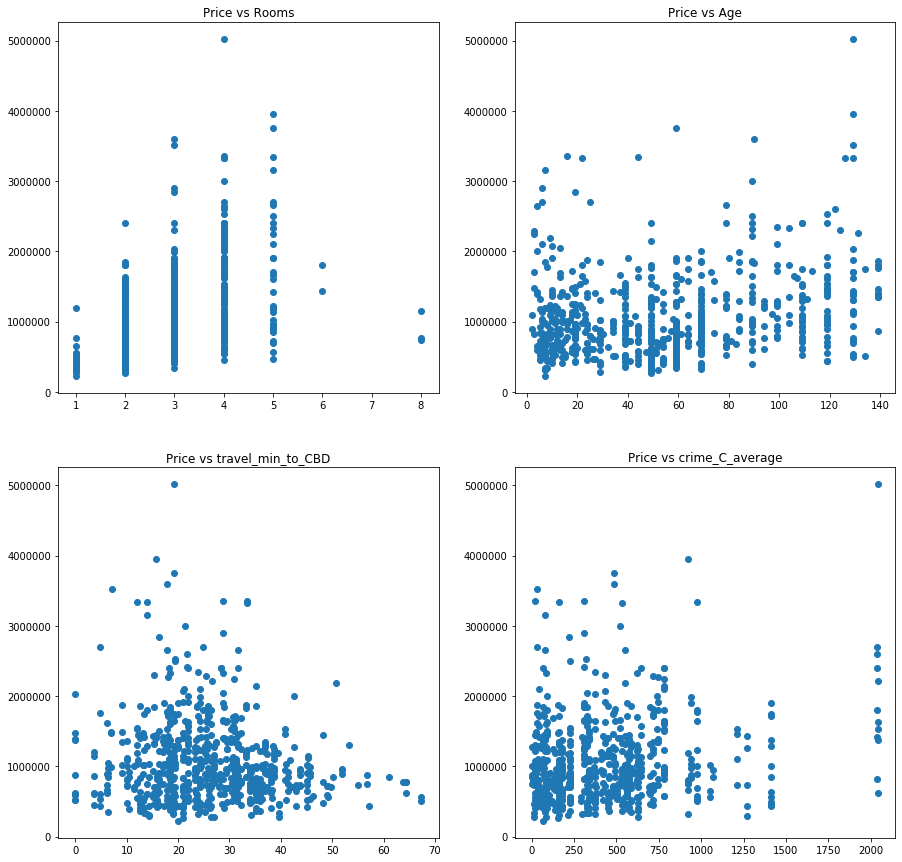

In [69]:
fig, axs = plt.subplots(2, 2, figsize =(15,15) )
axs[0, 0].scatter(df_original['Rooms'], df_original['Price'])
axs[0, 0].set_title('Price vs Rooms')
axs[0, 1].scatter(df_original['Age'], df_original['Price'])
axs[0, 1].set_title('Price vs Age')
axs[1, 0].scatter(df_original['travel_min_to_CBD'], df_original['Price'])
axs[1, 0].set_title('Price vs travel_min_to_CBD')
axs[1, 1].scatter(df_original['crime_C_average'], df_original['Price'])
axs[1, 1].set_title('Price vs crime_C_average')

The scatter plot above does not show the clear trend of linearity. Therefore, we will use the following transformation methods on each attribute to make it satisfy the assumption and choose the best transformation method
1. log transformation
2. root transformation
3. power transformation

We will start investigating `Rooms` first
### Rooms
The scatter plot of Rooms seem to show a little linear trend yet it is not that clear, so we will try on every transformation methods and measure correlation to assure the best one.

In [70]:
# build dataframe 
df_transform = pd.DataFrame()
# Root transformation
df_transform['Rooms_sqrt'] = df_original['Rooms'].map(sqrt)
# Log transformtion
df_transform['Rooms_log'] = df_original['Rooms'].map(log)
# Power transformation
df_transform['Rooms_pow'] = df_original['Rooms']**2

We can make a decision on whether which transformation methods to implement by comparing `correlation` between each case.
By doing that we will build a function to calculate all the correlation at once.

In [71]:
def cor(y):
    print(y+' vs Price')
    c,_ =pearsonr(df_original[y] ,df_original['Price'])
    print('Correlation of original {:.2f}'.format(c))
    c_log,_ =pearsonr(df_transform[y+'_log'] ,df_original['Price'])
    print('Correlation of log transformation {:.2f}'.format(c_log))
    c_sqrt,_ =pearsonr(df_transform[y+'_sqrt'] ,df_original['Price'])
    print('Correlation of square root transformation {:.2f}'.format(c_sqrt))
    c_power,_ =pearsonr(df_transform[y+'_pow'] ,df_original['Price'])
    print('Correlation of power transformation {:.2f}\n'.format(c_power))

In [72]:
cor('Rooms')

Rooms vs Price
Correlation of original 0.45
Correlation of log transformation 0.46
Correlation of square root transformation 0.46
Correlation of power transformation 0.39



There is a stronger linear relationship for `Rooms` after log transformation or square root transformation since both of them are closer to 1 more than the original attribute.

Thus, for **Rooms** we will be using one of **log transformation or square root transformation**

Then we will transform the next attribute..
### Age
The scatter plot of Age, data scatter on the bottomand in the middle so as we did to Rooms, we will try all the transformation and choose the best one.

In [73]:
# Root transformation
df_transform['Age_sqrt'] = df_original['Age'].map(sqrt)
# Log transformtion
df_transform['Age_log'] = df_original['Age'].map(log)
# Power transformation
df_transform['Age_pow'] = df_original['Age']**2

In [74]:
cor('Age')

Age vs Price
Correlation of original 0.25
Correlation of log transformation 0.13
Correlation of square root transformation 0.20
Correlation of power transformation 0.30



There is a stronger linear relationship for `Age` after power transformation since it is closer to 1 more than the original attribute.

Thus, for **Age** we will be using one of **power transformation**

Then we will transform the next attribute..
### travel_min_to_CBD
The data point on scatter plot of travel_min_to_CBD scatter at one area which again does ot show a clear trend, we will do the same as the previous two attributes.
Since as we saw on describe() that there is 0 in travel_min_to_CBD, we will calculate 0 with log(x-(min(x)-1) which would be 1 instead of 0.

In [75]:
#substitute 1 to 0
df_original.loc[df_original['travel_min_to_CBD']== 0,'travel_min_to_CBD'] = 1
# Root transformation
df_transform['travel_min_to_CBD_sqrt'] = df_original['travel_min_to_CBD'].map(sqrt)
# Log transformtion
df_transform['travel_min_to_CBD_log'] = df_original['travel_min_to_CBD'].map(log)
# Power transformation
df_transform['travel_min_to_CBD_pow'] = df_original['travel_min_to_CBD']**2

In [76]:
cor('travel_min_to_CBD')

travel_min_to_CBD vs Price
Correlation of original -0.12
Correlation of log transformation -0.06
Correlation of square root transformation -0.10
Correlation of power transformation -0.15



There is a stronger linear relationship for `travel_min_to_CBD` after power transformation since it is closer to 1 more than the original attribute.

Thus, for **travel_min_to_CBD** we will be using one of **power transformation**

Then we will transform the next attribute..
### crime_C_average
The data point on scatter plot of crime_C_average scatter around the origin and does not show much linearity, we will do the same as previously.

In [77]:
# Root transformation
df_transform['crime_C_average_sqrt'] = df_original['crime_C_average'].map(sqrt)
# Log transformtion
df_transform['crime_C_average_log'] = df_original['crime_C_average'].map(log)
# Power transformation
df_transform['crime_C_average_pow'] = df_original['crime_C_average']**2

In [78]:
cor('crime_C_average')

crime_C_average vs Price
Correlation of original 0.17
Correlation of log transformation 0.10
Correlation of square root transformation 0.14
Correlation of power transformation 0.20



There is a stronger linear relationship for `crime_C_average` after power transformation since it is closer to 1 more than the original attribute.

Thus, for **crime_C_average** we will be using one of **power transformation**

In conclusion, there is strong linear relationships between dependent and independent variable as the following:
- Rooms : Correlation of log transformation 0.46
- Age : Correlation of power transformation 0.30
- travel_min_to_CBD : Correlation of power transformation -0.15
- crime_C_average : Correlation of power transformation 0.20

Now we will create a new dataframe for our choosen of transformation of attributes and target 

In [79]:
df_chosen_transform = pd.DataFrame()
df_chosen_transform['Price'] =df_original['Price']
df_chosen_transform['trans_Rooms'] =df_transform['Rooms_log']
df_chosen_transform['trans_Age'] =df_transform['Age_pow']
df_chosen_transform['trans_travel'] =df_transform['travel_min_to_CBD_pow']
df_chosen_transform['trans_crime'] =df_transform['crime_C_average_pow'] 
df_chosen_transform.head()

,Price,trans_Rooms,trans_Age,trans_travel,trans_crime
0,735000.0,1.098612,16641.0,37.119684,1089.000000
1,2035000.0,1.098612,16641.0,1.000000,140875.111111
2,703000.0,1.098612,3481.0,1235.020408,25387.111111
3,710000.0,1.098612,3481.0,2476.976331,2567.111111
4,1100000.0,1.098612,324.0,331.760204,114469.444444


You can see from the dataframe `'df_chosen_transform'` that the dependent variables are measured in different units and do not contribute equally to the analysis which might lead to a bias. 

In order to deal with it, we will standardize using `z-score normalization` on each of the independent variable to make the value around the center and 0 with a standard deviation of 1.

We use scikit-learn linrary for standardise data (mean=0, SD=1). The class you are going to use is the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> class.

In [80]:
std_scale = preprocessing.StandardScaler()
df_std = std_scale.fit_transform(df_chosen_transform[['Price','trans_Rooms','trans_Age','trans_travel','trans_crime']])
df_std[0:5]
# put it alongside data... to view
df_normal = pd.DataFrame()
df_normal['Price_scaled'] = df_std[:,0] # so 'Price_scaled' is Price scaled
df_normal['Rooms_scaled'] = df_std[:,1] # and 'Rooms_scaled' is Rooms scaled
df_normal['Age_scaled'] = df_std[:,2] # and 'crime_scaled' is crime acid scaled
df_normal['travel_scaled'] = df_std[:,3] # and 'travel_scaled' is travel scaled
df_normal['crime_scaled'] = df_std[:,4] #and 'Age_scaled' is Age scaled
df_normal.head()

,Price_scaled,Rooms_scaled,Age_scaled,travel_scaled,crime_scaled
0,-0.552670,0.194871,2.456323,-1.119309,-0.508593
1,1.624738,0.194871,2.456323,-1.172821,-0.288114
2,-0.606268,0.194871,-0.198947,0.655418,-0.470268
3,-0.594544,0.194871,-0.198947,2.495414,-0.506261
4,0.058679,0.194871,-0.835930,-0.682790,-0.329763


In [87]:
df_normal.describe()

,Price_scaled,Rooms_scaled,Age_scaled,travel_scaled,crime_scaled
count,6.810000e+02,6.810000e+02,6.810000e+02,6.810000e+02,6.810000e+02
mean,-4.173526e-17,3.149708e-16,9.912123e-17,6.390711e-17,-1.043381e-17
std,1.000735e+00,1.000735e+00,1.000735e+00,1.000735e+00,1.000735e+00
min,-1.411909e+00,-2.968452e+00,-9.004956e-01,-1.172821e+00,-5.103087e-01
25%,-6.699155e-01,-9.726171e-01,-7.945672e-01,-6.815975e-01,-4.729041e-01
50%,-2.679324e-01,1.948714e-01,-4.168571e-01,-2.307543e-01,-3.297627e-01
75%,4.271635e-01,1.948714e-01,3.579330e-01,3.477792e-01,3.254614e-02
max,6.624404e+00,3.019053e+00,2.997062e+00,5.542628e+00,6.068622e+00


Now, compute and display the normalised values for features. Let's check if they have mean of 0 and SD= 1.

In [81]:
print('Mean after standardisation:\nPrice = {:.2f}, Room = {:.2f}, crime_C_average = {:.2f}, travel_min_to_CBD = {:.2f}, Age = {:.2f}'
      .format(df_std[:,0].mean(), df_std[:,1].mean(), df_std[:,2].mean(), df_std[:,3].mean(), df_std[:,4].mean()))
print('\nStandard deviation after standardisation:\nPrice = {:.2f}, Room = {:.2f}, crime_C_average = {:.2f}, travel_min_to_CBD = {:.2f}, Age = {:.2f}'
      .format(df_std[:,0].std(), df_std[:,1].std(), df_std[:,2].std(), df_std[:,3].std(), df_std[:,4].std()))

Mean after standardisation:
Price = -0.00, Room = 0.00, crime_C_average = 0.00, travel_min_to_CBD = 0.00, Age = -0.00

Standard deviation after standardisation:
Price = 1.00, Room = 1.00, crime_C_average = 1.00, travel_min_to_CBD = 1.00, Age = 1.00


After we scale the variable into the same proportion, we will now build linear models and implement statistical test to make the best version of linear model
## Building Linear Model
 we will now build 3 linear models for each of the following scenarios.
 
 1. Linear model with original data 
 2. Linear model with transformed data
 3. Linear model with both transformed and standardized data
### 1. Linear model with initial data

In [82]:
X_1 = df_original[['Rooms','crime_C_average','travel_min_to_CBD','Age']]
y_1 = df_original['Price']
X_train, X_test, y_train, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
y_pred_1 = regressor.predict(X_test)
df_1 = pd.DataFrame({'Actual': y_test_1, 'Predicted': y_pred_1})

### 2. Linear model with transformed data

In [83]:
X_2 = df_chosen_transform[['trans_Rooms','trans_crime','trans_travel','trans_Age']]
y_2 = df_original['Price']
X_train, X_test, y_train, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=0)
regressor_2 = LinearRegression()  
regressor_2.fit(X_train, y_train) #training the algorithm
y_pred_2 = regressor_2.predict(X_test)
df_2 = pd.DataFrame({'Actual': y_test_2, 'Predicted': y_pred_2})

### 3. Linear model with both transformed and standardized data

In [84]:
X_3 = df_normal[['Rooms_scaled','crime_scaled','travel_scaled','Age_scaled']]
y_3 = df_original['Price']
X_train, X_test, y_train, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=0)
regressor_3 = LinearRegression()  
regressor_3.fit(X_train, y_train) #training the algorithm
y_pred_3 = regressor_3.predict(X_test)
df_3 = pd.DataFrame({'Actual': y_test_3, 'Predicted': y_pred_3})

In order to decide which model best predict the `Price`, we will create a function called `evaluate()` to output 
1. R-squared
2. Mean Absolute Error
3. Mean Squared Error 
4. Root Mean Squared Error

In [85]:
def evaluate(method ,y_test, y_pred):
    print(method)
    print('R-squared for this model:', r2_score(y_test, y_pred)) 
    print('Mean Absolute Error for this model:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error for this model:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error for this model:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('\n')

In [86]:
evaluate('Original' ,y_test_1, y_pred_1)
evaluate('Transformation' ,y_test_2, y_pred_2)
evaluate('Transform and Normalization' ,y_test_3, y_pred_3)

Original
R-squared for this model: 0.3527643335429239
Mean Absolute Error for this model: 340207.38397000387
Mean Squared Error for this model: 195454118001.47302
Root Mean Squared Error for this model: 442101.9316871088


Transformation
R-squared for this model: 0.3610522715480753
Mean Absolute Error for this model: 338996.2453370488
Mean Squared Error for this model: 192951302262.47794
Root Mean Squared Error for this model: 439262.2249436866


Transform and Normalization
R-squared for this model: 0.3610522715480756
Mean Absolute Error for this model: 338996.2453370485
Mean Squared Error for this model: 192951302262.47784
Root Mean Squared Error for this model: 439262.2249436865




As we can see from the `R-Squared` of three distribution above, the model with the highest `R-Squared` is `'Transform and Normalization'` model which can be interpret that the data is closest to the fitted line the most among all the model we created.

## Conclusion
- The transformation is applied when we want to change the distribution or the shape of data to satisfy the statistical assumptions made when fitting model. It will translate each point in your input data set to selected functional output of that point.
- The normalization is applied when data have different range to prevent the remove amplitude variation and only focus on the underlying distributribution shape. It prevent bias in our model by not letting high range variable influent the model.
- In linear regression, the normalization have not much affect on model. We use normalization to avoid input variables dominate each other because of their range value.
- Note that it is possible to perform both data transformation and data normalization on the same variable and data transformation need to start first.
- We don't need to scale target variable since it have no effect on R-Squared yet the affect will just be on the Error

## Reference
- Editor, M. (2019). Regression Analysis: How Do I Interpret R-squared and Assess the Goodness-of-Fit?. Retrieved 27 October 2019, from https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit
- Assumptions of Multiple Linear Regression - Statistics Solutions. (2019). Retrieved 27 October 2019, from https://www.statisticssolutions.com/assumptions-of-multiple-linear-regression/
- Haversine Formula in Python (Bearing and Distance between two GPS points). Retrieved 27 October 2019, from
 https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
- From XML to Pandas dataframes. Retrieved 27 October 2019, from https://medium.com/@robertopreste/from-xml-to-pandas-dataframes-9292980b1c1c